In [9]:
%load_ext autoreload
%autoreload 2

import sys
import os
import sklearn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from osgeo import gdal
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LogisticRegression

sys.path.insert(1, os.path.join(sys.path[0], ".."))
from reproduction.pipeline import load as pipeline
from reproduction.analysis import AEData, plot_cluster_channel_distributions, plot_cluster_samples

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
model_dir = "../output/mod09cnn13/"

with open(model_dir + "ae.json", "r") as f:
    ae = tf.keras.models.model_from_json(f.read())
ae.load_weights(model_dir + "ae.h5")

In [3]:
def filename_contains_fn(substr):
    def fn (fnames, _, __):
        return tf.py_func(lambda fname: substr in str(fname), [fnames[0]], tf.bool, False)
    return fn

In [4]:
labeled_data =  pipeline.load_data(
    data_glob="../data/closed_open_cell/*.tfrecord",
    shape=(128, 128, 7),
    batch_size=32,
    read_threads=4,
    shuffle_buffer_size=100,
    prefetch=2
)

In [5]:
open_cells = labeled_data.filter(filename_contains_fn("open-cell"))
closed_cells = labeled_data.filter(filename_contains_fn("closed-cell"))

# Logistic Regression (Open vs Closed Cell Stratocumulus)

In [27]:
fields = ["b%d"%(i+1) for i in range(7)]
n_test = 100
n_train = 2000
n = n_train + n_test

In [28]:
opens = AEData(open_cells, ae, fields, n)
closeds = AEData(closed_cells, ae, fields, n)

In [29]:
for d in (opens, closeds):
    nuniq = len(set((tuple(a), b) for a, b in zip(d.coords, d.names)))
    assert nuniq == n_test + n_train

## Baseline: Logistic regression using only patch mean and stdev

In [30]:
base_features = np.stack([ 
    np.concatenate([opens.imgs.mean(axis=(1,2,3)), closeds.imgs.mean(axis=(1,2,3))]),
    np.concatenate([opens.imgs.std(axis=(1,2,3)), closeds.imgs.std(axis=(1,2,3))])
], axis=1)

lr_b = LogisticRegression().fit(
    X=np.concatenate([
        base_features[:n_train],
        base_features[n: n+n_train]
    ]),
    y=([0] * n_train + [1] * n_train))

lr_b.score(
    X=np.concatenate([base_features[n_train:n], base_features[n + n_train:]]),
    y=([0] * n_test + [1] * n_test),
)

0.54

In [31]:
base_features.std(axis=0)

array([0.6257706, 0.2675887], dtype=float32)

In [32]:
lr_b.coef_

array([[-0.02176081, -0.41599479]])

## Logistic Regression on AE features

In [33]:
ofeat = np.reshape(opens.raw_encs, (n, -1))
cfeat = np.reshape(closeds.raw_encs, (n, -1))


lr = LogisticRegression(penalty="l1").fit(
    X=np.concatenate([ofeat[:n_train], cfeat[:n_train]]),
    y=([0] * n_train + [1] * n_train),
)
lr.score(
    X=np.concatenate([ofeat[n_train:], cfeat[n_train:]]),
    y=([0] * n_test + [1] * n_test),
)

0.54

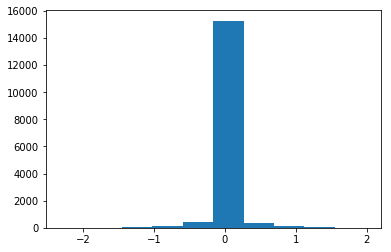

In [34]:
plt.hist(lr.coef_.ravel());

## Logistic Regression on Spatially Averaged AE features

In [62]:
ofeat = opens.encs
cfeat = closeds.encs

lr = LogisticRegression(penalty="l2").fit(
    X=np.concatenate([ofeat[:n_train], cfeat[:n_train]]),
    y=([0] * n_train + [1] * n_train),
)
lr.score(
    X=np.concatenate([ofeat[n_train:], cfeat[n_train:]]),
    y=([0] * n_test + [1] * n_test),
)

0.605

## Logistic Regression on mean/std of AE features


In [55]:
_features = np.stack([ 
    np.concatenate([ofeat.mean(axis=1), cfeat.mean(axis=1)]),
    np.concatenate([ofeat.std(axis=1), cfeat.std(axis=1)])
], axis=1)

lr = LogisticRegression().fit(
    X=np.concatenate([
        _features[:n_train],
        _features[n: n+n_train]
    ]),
    y=([0] * n_train + [1] * n_train)
)

lr.score(
    X=np.concatenate([_features[n_train:n], _features[n + n_train:]]),
    y=([0] * n_test + [1] * n_test),
)

0.61

In [56]:
lr_b.coef_

array([[-0.02176081, -0.41599479]])

## Logistic Regression on top 3 Principle Components of AE features


In [57]:
data = AEData(
    dataset=pipeline.load_data(
        data_glob="../data/tif/*.tfrecord",
        shape=(128, 128, 7),
        batch_size=32,
        read_threads=4,
        shuffle_buffer_size=100,
        prefetch=2
    ),
    ae=ae,
    fields=["b%d"%(i+1) for i in range(7)],
    n=1000
)

In [58]:
d = 256

In [59]:
_features = np.concatenate([
    data.pca_project(opens, d).T,
    data.pca_project(closeds, d).T
])

lr = LogisticRegression(penalty="l1").fit(
    X=np.concatenate([
        _features[:n_train],
        _features[n: n+n_train]
    ]),
    y=([0] * n_train + [1] * n_train)
)

lr.score(
    X=np.concatenate([_features[n_train:n], _features[n + n_train:]]),
    y=([0] * n_test + [1] * n_test),
)

0.625

Rotating into principle component axis improves things a bit, I think its because the L1 regularization is axis aligned. PCA has independent components.

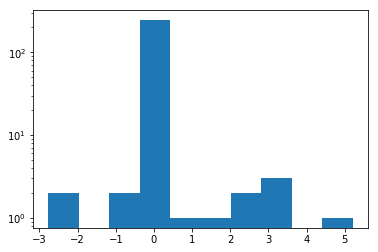

In [51]:
plt.hist(lr.coef_.ravel());
plt.yscale("log")